In [1]:
# ЧЕРНОВОЙ ВАРИАНТ STABLE DIFFUSION ONE
# README https://habr.com/ru/companies/samolet/articles/825750/
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# СОЗДАЕМ ПАПКУ PROJECT на ГУГЛ ДИСКЕ
!mkdir -p /content/drive/MyDrive/PROJECT

In [3]:
# ОТКРЫВАЕМ ССЫЛКУ и в МОЙ ДИСК - PROJECT добавляем через меню правой кнопки Систематизировать data - https://drive.google.com/drive/folders/1RKSFIntGnprref8XhFInNLXuzVA_xfJl?usp=sharing
!find /content/drive/MyDrive/PROJECT/data

/content/drive/MyDrive/PROJECT/data
/content/drive/MyDrive/PROJECT/data/images
/content/drive/MyDrive/PROJECT/data/images/56.JPG
/content/drive/MyDrive/PROJECT/data/images/56.png
/content/drive/MyDrive/PROJECT/data/img5001_BDorig.png


In [4]:
!pip install diffusers

In [5]:
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def display_images(images: dict | list, show_axes: bool = True, grid: tuple = (1, None), figsize: tuple = (15, 5), tight_layout: bool = True):
    if isinstance(images, list):
        titles = []
        for i, img in enumerate(images):
            if isinstance(img, np.ndarray):
                if len(img.shape) == 2:
                    mode = "L"
                if img.shape[2] == 3:
                    mode = 'RGB'
                if img.shape[2] == 4:
                    mode = 'RGBA'
                else:
                    mode = 'N/A'
                title = f"img{i}, {img.shape}, {mode}, N/A"
            else:
                title = f"img{i}, {img.size}, {img.mode}, {img.format}"
            titles.append(title)

        images_with_titles = dict(zip(titles, images))
    else:
        images_with_titles = images

    num_images = len(images_with_titles)
    rows, cols = grid if grid[1] is not None else (grid[0], max(1, num_images // grid[0]))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if num_images > 1 else [axes]

    for ax, (title, image) in zip(axes, images_with_titles.items()):
        ax.imshow(image if isinstance(image, np.ndarray) else np.array(image))
        ax.set_title(title)
        if not show_axes:
            ax.axis('off')

    if tight_layout:
        plt.tight_layout()
    plt.show()

#
def simple_ae_plot():
    # Определение координат точек
    x_values = np.array([-1, 0, 1, 2, 3, 4])
    y_values = x_values  # h = x1 + x2, простая линия y=x

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(x_values, y_values, color='black', marker='o', mfc='green', markeredgecolor='green')
    axs[0].set_title('$h_1 = x_1 + x_2$')
    axs[0].axhline(0, color='black', linewidth=0.5)
    axs[0].axvline(0, color='black', linewidth=0.5)
    axs[0].hlines(y=2, xmin=0, xmax=2, linestyle='--', color='gray')
    axs[0].vlines(x=2, ymin=0, ymax=2, linestyle='--', color='gray')
    axs[0].set_xticks(x_values)
    axs[0].set_yticks(y_values)
    axs[0].set_xlabel('$x_1$')
    axs[0].set_ylabel('$x_2$')

    axs[1].plot(x_values, y_values, color='black', marker='o', mfc='green', markeredgecolor='green')
    axs[1].set_title('$h_1 = x_1 + x_2$')
    axs[1].axhline(0, color='black', linewidth=0.5)
    axs[1].axvline(0, color='black', linewidth=0.5)
    axs[1].set_xticks(x_values)
    axs[1].set_yticks(y_values)
    axs[1].set_xlabel('$x_1$')
    axs[1].set_ylabel('$x_2$')

    x1, y1 = 1, 3
    x2, y2 = 2, 2

    axs[1].hlines(y=y2, xmin=0, xmax=x2, linestyle=':', color='green')
    axs[1].vlines(x=x2, ymin=0, ymax=y2, linestyle=':', color='green')
    axs[1].annotate(f'(2, 2)', (2, 2), textcoords="offset points", xytext=(10, -10), ha='left', va='top')

    axs[1].plot(x1, y1, marker='o', mfc='red', markeredgecolor='red')
    axs[1].hlines(y=y1, xmin=0, xmax=x1, linestyle=':', color='red')
    axs[1].vlines(x=x1, ymin=0, ymax=y1, linestyle=':', color='red')
    axs[1].annotate(f'(1, 3)', (1, 3), textcoords="offset points", xytext=(0, 10), ha='right')

    plt.arrow(x1, y1, x2 - x1, y2 - y1, lw=1, length_includes_head=True, head_width=0.15, color='gray')

    # Показать график
    plt.tight_layout()
    plt.show()


def forward_diffusion_process(image, steps, beta):
    images_with_titles = {'Original': image}
    for step in range(1, steps + 1):
        image = forward_diffusion_step(image, step, beta)
        images_with_titles[f'Step {step}'] = image
    display_images(images_with_titles, show_axes=False)


def forward_diffusion_step(image, step, beta):
    """
    Применяет гауссовский шум к изображению согласно формуле зашумления.
    q(x_t | x_{t-1}) = N(x_t; μ_t = (1 - β_t) * x_{t-1}, Σ_t = β_t * I)
    """
    image_array = np.array(image)
    image_array = image_array / 255.0
    mean = (1 - beta) * image_array
    sigma = np.sqrt(beta)
    noisy_image_array = mean + sigma * np.random.randn(*image_array.shape) # Добавление гауссовского шума
    noisy_image_array = np.clip(noisy_image_array, 0, 1)
    noisy_image_array = (255 * noisy_image_array).astype(np.uint8)
    noisy_image = Image.fromarray(noisy_image_array)
    return noisy_image

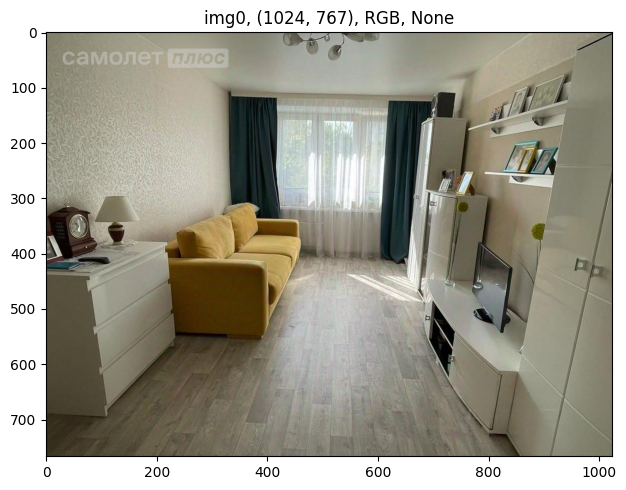

In [6]:
import cv2
import torch
import numpy as np
from PIL import Image
# from utils import display_images


DEVICE = 'cuda:0'
CACHE_DIR = '/home/a.lugovoi/Git/rnd-tasks/generative-ai-research/cache'
img_pil = Image.open('/content/drive/MyDrive/PROJECT/data/img5001_BDorig.png').convert('RGB')
display_images([img_pil])

# Step 1: simple img2img
## img2img stable-diffusion-v15


*   https://huggingface.co/docs/diffusers/en/using-diffusers/img2img#stable-diffusion-v15


/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:25: FutureWarning: `VQModel` is deprecated and will be removed in version 0.31. Importing `VQModel` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQModel`, instead.
  deprecate("VQModel", "0.31", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the H

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

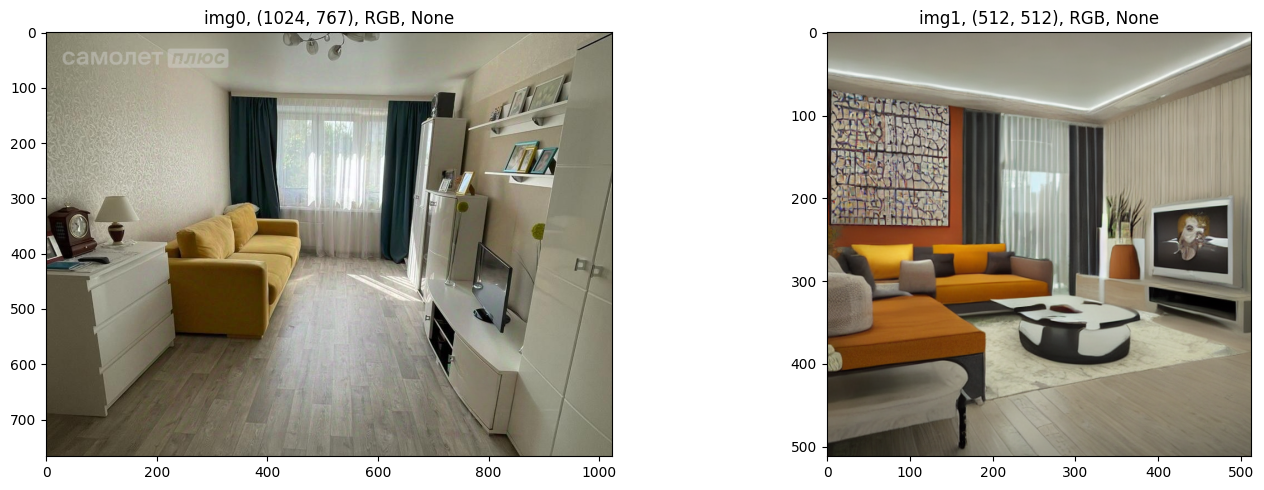

CPU times: user 33.5 s, sys: 9.47 s, total: 42.9 s
Wall time: 1min 8s


In [7]:
%%time

from diffusers import AutoPipelineForImage2Image

pipe = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    cache_dir=CACHE_DIR
).to(DEVICE)

prompt = "New modern style of livingroom, warm color palette, detailed, 8k"
img_gen = pipe(prompt, image=img_pil.resize((512, 512)), strenght=0.7, num_inference_steps=100)
display_images([img_pil] + img_gen.images)